# 생체인증보안 1871085 멀티모달 2차 답안

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4314997871119214448
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10768720896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7836025216193438671
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1"
]


In [2]:
# 라이브러리 import
import PIL.Image as pilimg
import numpy as np
import glob
import matplotlib.pyplot as plt
import re

In [3]:
# 이미지 목록
images_face = sorted(glob.glob('./04_multimodal_training/*.BMP'))
images_iris = sorted(glob.glob('./04_multimodal_training/*.png'))

print(len(images_face), len(images_iris))

256 256


In [4]:
r = re.compile('\d+')

img_face = [] # 이미지
img_iris = [] # 이미지
label_face = [] # 라벨
label_iris = [] # 라벨

for fname in images_face:
    l = r.findall(fname)[1]
    label_face.append(l)
    im = pilimg.open(fname)
    im = im.resize((153,115))
    pix = np.array(im)/255.
    pix = pix.reshape(pix.shape[0], pix.shape[1], 1)
    pix = tf.image.grayscale_to_rgb(tf.convert_to_tensor(pix)) # ResNet50 위해 rgb 이미지로 변환
    img_face.append(pix)
    
for fname in images_iris:
    l = r.findall(fname)[1]
    label_iris.append(l)
    im = pilimg.open(fname)
    im = im.resize((int(im.width*0.2), int(im.height*0.2))) # 이미지 줄이기
    pix = np.array(im)/255. # Normalize
    img_iris.append(pix)

In [5]:
X_face = np.array(img_face)
X_iris = np.array(img_iris)
print(X_face.shape, X_iris.shape)

(256, 115, 153, 3) (256, 115, 153, 3)


In [6]:
y_face = np.array(label_face, dtype='int32')
y_iris = np.array(label_iris, dtype='int32')

print(y_face) # face label
print(y_iris) # iris label

[ 0  0  0  0  1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5
  6  6  6  6  7  7  7  7  8  8  8  8  9  9  9  9 10 10 10 10 11 11 11 11
 12 12 12 12 13 13 13 13 14 14 14 14 15 15 15 15 16 16 16 16 17 17 17 17
 18 18 18 18 19 19 19 19 20 20 20 20 21 21 21 21 22 22 22 22 23 23 23 23
 24 24 24 24 25 25 25 25 26 26 26 26 27 27 27 27 28 28 28 28 29 29 29 29
 30 30 30 30 31 31 31 31 32 32 32 32 33 33 33 33 34 34 34 34 35 35 35 35
 36 36 36 36 37 37 37 37 38 38 38 38 39 39 39 39 40 40 40 40 41 41 41 41
 42 42 42 42 43 43 43 43 44 44 44 44 45 45 45 45 46 46 46 46 47 47 47 47
 48 48 48 48 49 49 49 49 50 50 50 50 51 51 51 51 52 52 52 52 53 53 53 53
 54 54 54 54 55 55 55 55 56 56 56 56 57 57 57 57 58 58 58 58 59 59 59 59
 60 60 60 60 61 61 61 61 62 62 62 62 63 63 63 63]
[ 0  0  0  0  1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5
  6  6  6  6  7  7  7  7  8  8  8  8  9  9  9  9 10 10 10 10 11 11 11 11
 12 12 12 12 13 13 13 13 14 14 14 14 15 15 15 15 16 16 16 16 17 17 17 17
 

(115, 153, 3)
0


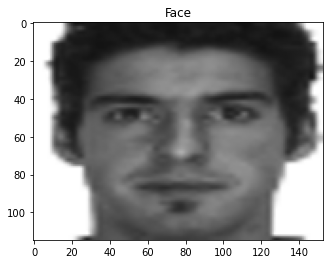

In [7]:
# 0번 사람의 얼굴 이미지
plt.title('Face')
plt.imshow(X_face[0])
print(X_face[0].shape)
print(y_face[0])

(115, 153, 3)
0


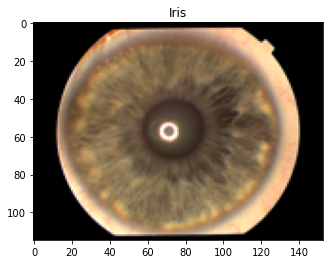

In [8]:
# 0번 사람의 홍채 이미지
plt.title('Iris')
plt.imshow(X_iris[0])
print(X_iris[0].shape)
print(y_iris[0])

# Data Augmentation

In [9]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.Add(0,1),
    iaa.GaussianBlur(sigma=(0.0, 0.9)),
    iaa.Fliplr(0.5), # 수평
    #iaa.Flipud(0.5) # 수직
], random_order=True)

def aug_data(X_data, y_data):
    augmentated_data = [] # 생성한 이미지
    augmentated_label = [] # 생성한 이미지의 라벨
    for i in range(len(X_data)):
        augs = [X_data[i]] * 4 # 이미지당 9개 추가 생성
        augs = seq.augment_images(augs)
        for aug in augs:
            augmentated_data.append(aug)
            augmentated_label.append(y_data[i])
    
    return augmentated_data, augmentated_label

In [10]:
face_x_d, face_y_d = aug_data(X_face.astype('float32'), y_face) # Face 이미지 생성
print(len(face_x_d), len(face_y_d))
iris_x_d, iris_y_d = aug_data(X_iris.astype('float32'), y_iris) # Iris 이미지 생성
print(len(iris_x_d), len(iris_y_d))

1024 1024
1024 1024


(115, 153, 3)
0


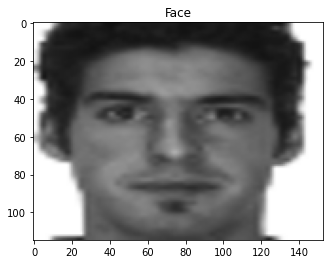

In [11]:
# 생성한 얼굴 이미지
plt.title('Face')
plt.imshow(face_x_d[0])
print(face_x_d[0].shape)
print(face_y_d[0])

(115, 153, 3)
0


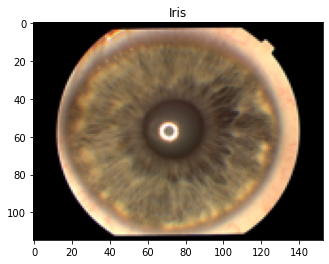

In [12]:
# 생성한 홍채 이미지
plt.title('Iris')
plt.imshow(iris_x_d[0])
print(iris_x_d[0].shape)
print(iris_y_d[0])

In [13]:
# 기존 이미지
print(X_face.shape)
print(y_face.shape)
print(X_iris.shape)
print(y_iris.shape)

# 생성한 이미지
face_x_d = np.array(face_x_d)
face_y_d = np.array(face_y_d)
print(face_x_d.shape)
print(face_y_d.shape)
iris_x_d = np.array(iris_x_d)
iris_y_d = np.array(iris_y_d)
print(iris_x_d.shape)
print(iris_y_d.shape)

(256, 115, 153, 3)
(256,)
(256, 115, 153, 3)
(256,)
(1024, 115, 153, 3)
(1024,)
(1024, 115, 153, 3)
(1024,)


In [14]:
# 기존 이미지, 생성 이미지 합치기
X_face = np.concatenate([X_face, face_x_d], axis=0)
y_face = np.concatenate([y_face, face_y_d], axis=0)
X_iris = np.concatenate([X_iris, iris_x_d], axis=0)
y_iris = np.concatenate([y_iris, iris_y_d], axis=0)
print(X_face.shape)
print(X_iris.shape)

(1280, 115, 153, 3)
(1280, 115, 153, 3)


In [15]:
# X_data로 얼굴, 홍채 합치기
X_data = np.concatenate([X_face, X_iris], axis=1)
y_data = y_face # y_face=y_iris

In [16]:
X_data.shape

(1280, 230, 153, 3)

(230, 153, 3)
0


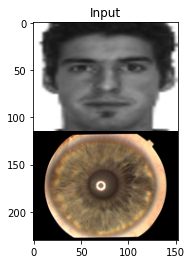

In [17]:
# 최종 input 이미지
plt.title('Input')
plt.imshow(X_data[0])
print(X_data[0].shape)
print(y_data[0])

# Data split

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=True, stratify=y_data, random_state=101)

In [19]:
X_train=X_train.astype('float32')
y_train=y_train.astype('int32')
X_test=X_test.astype('float32')
y_test=y_test.astype('int32')

In [20]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1024, 230, 153, 3) (1024,) (256, 230, 153, 3) (256,)


# Model

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam

In [22]:
def build_model():
    learning_rate = 0.0001
    METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy')
    ]

    input_ = Input(shape=X_data[0].shape, name='input')
    
    # base model
    base_model = ResNet50V2(include_top=False, input_tensor=input_)
    for layer in base_model.layers[:44]:
        layer.trainable=False
    
    y = base_model.output
    y = MaxPooling2D(pool_size=(2,2))(y)
    y = Flatten()(y)
    y = Dense(512, activation='relu', kernel_regularizer='l2')(y)
    y = Dropout(0.5)(y)
    y = Dense(128, activation='relu', kernel_regularizer='l2')(y)
    output = Dense(64, activation='softmax')(y)
    
    model = Model(input_, output)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=METRICS)
    return model    

build_model().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 230, 153, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 236, 159, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 115, 77, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 117, 79, 64)  0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [23]:
#Cross validation
from sklearn.model_selection import KFold
from keras.utils import to_categorical

kf = KFold(n_splits=4, shuffle=True, random_state=42)
all_history = [] # 결과 저장

def score_model(cv=None):
    if cv is None:
        cv = KFold(n_splits=4, random_state=42, shuffle=True)
        
    i=0
    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        i=i+1
        print('Fold #',i)
        # Get the training data
        X_train_fold = X_train[train_fold_index]
        y_train_fold = y_train[train_fold_index]
        
        # Get the validation data
        X_val_fold = X_train[val_fold_index]
        y_val_fold = y_train[val_fold_index]

        print(X_train_fold.shape)
        print(X_val_fold.shape)
        print(y_val_fold.shape)
        
        y_train_fold = to_categorical(y_train_fold, num_classes=64)
        y_val_fold = to_categorical(y_val_fold, num_classes=64)
        
        # Fit the model
        model = build_model()
        model_obj = model.fit(X_train_fold, y_train_fold,
                              epochs=100,
                              #batch_size=128,
                              validation_data=(X_val_fold, y_val_fold),
                              verbose=1)
        model.save('./model/multimodal_model1_'+str(i)+'.h5')
        all_history.append(model_obj.history)

# Example of the model in action
score_model(cv=kf)

Fold # 1
(768, 230, 153, 3)
(256, 230, 153, 3)
(256,)
Epoch 1/100
24/24 [==============================] - 54s 150ms/step - loss: 17.1154 - accuracy: 0.0926 - val_loss: 15.0371 - val_accuracy: 0.0977
Epoch 2/100
24/24 [==============================] - 3s 112ms/step - loss: 12.2466 - accuracy: 0.6249 - val_loss: 12.7707 - val_accuracy: 0.3594
Epoch 3/100
24/24 [==============================] - 3s 113ms/step - loss: 10.3476 - accuracy: 0.9241 - val_loss: 10.7488 - val_accuracy: 0.6758
Epoch 4/100
24/24 [==============================] - 3s 113ms/step - loss: 9.5776 - accuracy: 0.9590 - val_loss: 9.3637 - val_accuracy: 0.9180
Epoch 5/100
24/24 [==============================] - 3s 113ms/step - loss: 8.9953 - accuracy: 0.9857 - val_loss: 8.6666 - val_accuracy: 0.9883
Epoch 6/100
24/24 [==============================] - 3s 113ms/step - loss: 8.5574 - accuracy: 0.9947 - val_loss: 8.2757 - val_accuracy: 0.9961
Epoch 7/100
24/24 [==============================] - 3s 114ms/step - loss: 8.1848

24/24 [==============================] - 3s 115ms/step - loss: 6.4822 - accuracy: 0.9971 - val_loss: 6.3216 - val_accuracy: 1.0000
Epoch 14/100
24/24 [==============================] - 3s 117ms/step - loss: 6.2707 - accuracy: 0.9930 - val_loss: 6.1146 - val_accuracy: 1.0000
Epoch 15/100
24/24 [==============================] - 3s 118ms/step - loss: 6.0649 - accuracy: 0.9967 - val_loss: 5.9171 - val_accuracy: 1.0000
Epoch 16/100
24/24 [==============================] - 3s 119ms/step - loss: 5.8676 - accuracy: 1.0000 - val_loss: 5.7293 - val_accuracy: 1.0000
Epoch 17/100
24/24 [==============================] - 3s 117ms/step - loss: 5.6780 - accuracy: 0.9993 - val_loss: 5.5438 - val_accuracy: 1.0000
Epoch 18/100
24/24 [==============================] - 3s 117ms/step - loss: 5.4956 - accuracy: 1.0000 - val_loss: 5.3786 - val_accuracy: 0.9961
Epoch 19/100
24/24 [==============================] - 3s 116ms/step - loss: 5.3180 - accuracy: 0.9993 - val_loss: 5.1901 - val_accuracy: 1.0000
Epoch

Epoch 70/100
24/24 [==============================] - 3s 116ms/step - loss: 0.9945 - accuracy: 1.0000 - val_loss: 0.9678 - val_accuracy: 1.0000
Epoch 71/100
24/24 [==============================] - 3s 117ms/step - loss: 0.9603 - accuracy: 1.0000 - val_loss: 0.9349 - val_accuracy: 1.0000
Epoch 72/100
24/24 [==============================] - 3s 118ms/step - loss: 0.9291 - accuracy: 1.0000 - val_loss: 0.9031 - val_accuracy: 1.0000
Epoch 73/100
24/24 [==============================] - 3s 118ms/step - loss: 0.8961 - accuracy: 1.0000 - val_loss: 0.8722 - val_accuracy: 1.0000
Epoch 74/100
24/24 [==============================] - 3s 116ms/step - loss: 0.8651 - accuracy: 1.0000 - val_loss: 0.8421 - val_accuracy: 1.0000
Epoch 75/100
24/24 [==============================] - 3s 119ms/step - loss: 0.8355 - accuracy: 1.0000 - val_loss: 0.8131 - val_accuracy: 1.0000
Epoch 76/100
24/24 [==============================] - 3s 119ms/step - loss: 0.8066 - accuracy: 1.0000 - val_loss: 0.7851 - val_accuracy:

Epoch 83/100
24/24 [==============================] - 3s 122ms/step - loss: 0.6187 - accuracy: 1.0000 - val_loss: 0.6013 - val_accuracy: 1.0000
Epoch 84/100
24/24 [==============================] - 3s 116ms/step - loss: 0.5967 - accuracy: 1.0000 - val_loss: 0.5798 - val_accuracy: 1.0000
Epoch 85/100
24/24 [==============================] - 3s 116ms/step - loss: 0.5750 - accuracy: 1.0000 - val_loss: 0.5590 - val_accuracy: 1.0000
Epoch 86/100
24/24 [==============================] - 3s 116ms/step - loss: 0.5545 - accuracy: 1.0000 - val_loss: 0.5386 - val_accuracy: 1.0000
Epoch 87/100
24/24 [==============================] - 3s 115ms/step - loss: 0.5341 - accuracy: 1.0000 - val_loss: 0.5190 - val_accuracy: 1.0000
Epoch 88/100
24/24 [==============================] - 3s 118ms/step - loss: 0.5147 - accuracy: 1.0000 - val_loss: 0.5002 - val_accuracy: 1.0000
Epoch 89/100
24/24 [==============================] - 3s 116ms/step - loss: 0.4963 - accuracy: 1.0000 - val_loss: 0.4821 - val_accuracy:

Epoch 96/100
24/24 [==============================] - 3s 120ms/step - loss: 0.4083 - accuracy: 1.0000 - val_loss: 0.3979 - val_accuracy: 1.0000
Epoch 97/100
24/24 [==============================] - 3s 123ms/step - loss: 0.3938 - accuracy: 1.0000 - val_loss: 0.3854 - val_accuracy: 1.0000
Epoch 98/100
24/24 [==============================] - 3s 116ms/step - loss: 0.3816 - accuracy: 1.0000 - val_loss: 0.3706 - val_accuracy: 1.0000
Epoch 99/100
24/24 [==============================] - 3s 116ms/step - loss: 0.3702 - accuracy: 1.0000 - val_loss: 0.3595 - val_accuracy: 1.0000
Epoch 100/100
24/24 [==============================] - 3s 116ms/step - loss: 0.3570 - accuracy: 1.0000 - val_loss: 0.3459 - val_accuracy: 1.0000


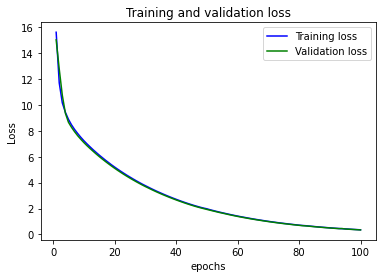

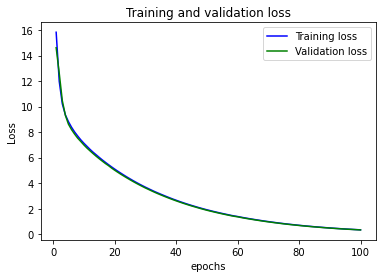

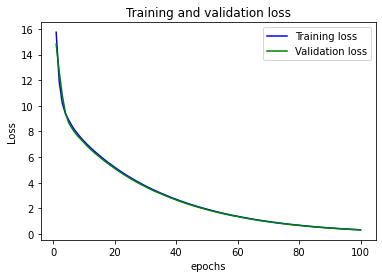

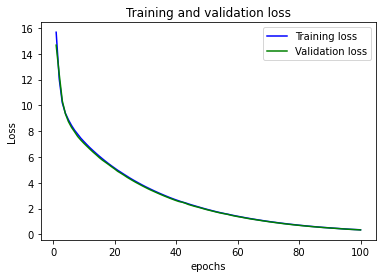

In [24]:
# Loss
for i in range(4):
    loss = all_history[i].get('loss') # train
    val_loss = all_history[i].get('val_loss') # val
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training loss')  # ‘b’는 파란색 실선을 의미합니다.
    plt.plot(epochs, val_loss, 'g', label='Validation loss') # ‘g’는 초록색 실선을 의미합니다.
    plt.title('Training and validation loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

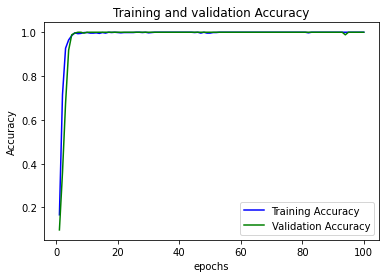

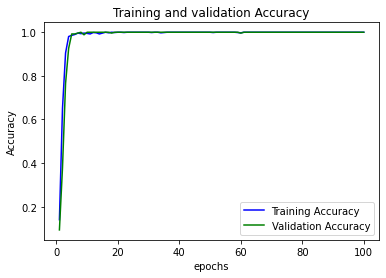

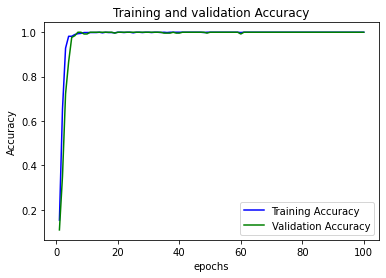

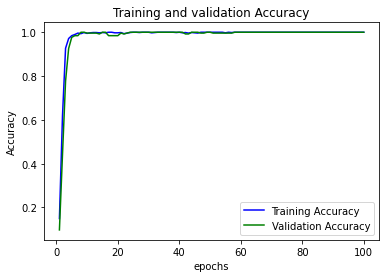

In [25]:
# Accuracy
for i in range(4):
    accuracy = all_history[i].get('accuracy') # train
    val_accuracy = all_history[i].get('val_accuracy') # val
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')  # ‘b’는 파란색 실선을 의미합니다.
    plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy') # ‘g’는 초록색 실선을 의미합니다.
    plt.title('Training and validation Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [26]:
from tensorflow.keras.models import load_model
model = load_model('./model/multimodal_model1_2.h5') ## 가장 학습과정이 좋아보이는 모델 로드

In [27]:
preds = np.argmax(model.predict(X_test), axis=1)
preds

array([ 9, 47, 34, 54, 26, 20, 15, 62, 23, 13, 58,  6,  1, 22, 37, 25, 62,
       38,  9, 38, 14, 24, 24, 45, 55, 29, 25, 19,  7, 34, 50,  3, 53, 42,
       16, 35, 16, 18, 59, 52, 60,  8, 15, 25, 40, 18, 20,  5, 34,  3,  4,
       38, 50, 12, 55, 58, 28, 41,  5, 24, 48, 35, 22, 47, 29,  2,  2, 63,
       37, 34,  7, 56, 52, 31, 48, 53, 33,  8, 17, 41, 54, 30, 38, 36,  6,
       43, 29, 61, 18, 28, 46, 57, 42, 18,  0, 35, 61, 52, 10, 14, 19, 48,
       14, 20,  1, 27, 27, 17,  9, 47, 63, 19, 11, 31, 16, 44, 53, 59, 23,
        4, 40, 56,  5,  0, 33, 24, 49,  8, 43, 33,  8,  2, 61,  7, 41, 27,
       55, 15, 61,  9, 11, 45, 26, 35, 40, 30,  2, 46, 32,  7, 44, 45, 10,
       12, 53,  1, 33,  3, 57, 60, 21, 23, 39, 16, 50, 43, 49, 13, 27,  0,
       57, 25, 45, 36, 10, 17, 63, 41, 57, 46, 55, 12, 32, 39, 49,  4,  6,
       17,  5, 32, 51, 31, 36, 54, 13, 56,  6, 30, 62, 22, 21, 19, 63, 31,
       26, 20, 52, 51, 15, 43, 13,  1, 51, 22, 11,  3, 11, 48, 37, 60,  4,
       28, 51, 58, 14, 42

In [28]:
y_test

array([ 9, 47, 34, 54, 26, 20, 15, 62, 23, 13, 58,  6,  1, 22, 37, 25, 62,
       38,  9, 38, 14, 24, 24, 45, 55, 29, 25, 19,  7, 34, 50,  3, 53, 42,
       16, 35, 16, 18, 59, 52, 60,  8, 15, 25, 40, 18, 20,  5, 34,  3,  4,
       38, 50, 12, 55, 58, 28, 41,  5, 24, 48, 35, 22, 47, 29,  2,  2, 63,
       37, 34,  7, 56, 52, 31, 48, 53, 33,  8, 17, 41, 54, 30, 38, 36,  6,
       43, 29, 61, 18, 28, 46, 57, 42, 18,  0, 35, 61, 52, 10, 14, 19, 48,
       14, 20,  1, 27, 27, 17,  9, 47, 63, 19, 11, 31, 16, 44, 53, 59, 23,
        4, 40, 56,  5,  0, 33, 24, 49,  8, 43, 33,  8,  2, 61,  7, 41, 27,
       55, 15, 61,  9, 11, 45, 26, 35, 40, 30,  2, 46, 32,  7, 44, 45, 10,
       12, 53,  1, 33,  3, 57, 60, 21, 23, 39, 16, 50, 43, 49, 13, 27,  0,
       57, 25, 45, 36, 10, 17, 63, 41, 57, 46, 55, 12, 32, 39, 49,  4,  6,
       17,  5, 32, 51, 31, 36, 54, 13, 56,  6, 30, 62, 22, 21, 19, 63, 31,
       26, 20, 52, 51, 15, 43, 13,  1, 51, 22, 11,  3, 11, 48, 37, 60,  4,
       28, 51, 58, 14, 42

(230, 153, 3)
예측:  9
실제:  9


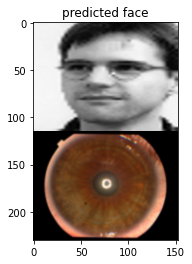

In [29]:
# 예측결과
plt.title('predicted face')
this_img = (X_test[0])
plt.imshow(this_img)
print(this_img.shape)
print('예측: ', preds[0])
print('실제: ', y_test[0])

# Result

In [30]:
from sklearn.metrics import mean_squared_error
# rmse
rmse = np.sqrt(mean_squared_error(y_test, preds)) 
print("RMSE: %f" % (rmse))

RMSE: 0.000000


In [31]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,preds))

[[4 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 4]]


In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test,preds, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         4
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00         4
          17       1.00    

## Test

In [38]:
# 이미지 목록
images_face = sorted(glob.glob('./04_multimodal_test/*face.png'))
images_iris = sorted(glob.glob('./04_multimodal_test/*iris.png'))

print(len(images_face), len(images_iris))

64 64


In [39]:
r = re.compile('\d+')

img_face_t = [] # 이미지
img_iris_t = [] # 이미지
num_face_t = [] # 라벨
num_iris_t = [] # 라벨

for fname in images_face:
    l = r.findall(fname)[1]
    num_face_t.append(l)
    im = pilimg.open(fname)
    im = im.resize((153,115)) # iris 크기
    pix = np.array(im)/255.
    pix = pix.reshape(pix.shape[0], pix.shape[1], 1)
    pix = tf.image.grayscale_to_rgb(tf.convert_to_tensor(pix)) # ResNet50 위해 rgb 이미지로 변환
    img_face_t.append(pix)
    
for fname in images_iris:
    l = r.findall(fname)[1]
    num_iris_t.append(l)
    im = pilimg.open(fname)
    im = im.resize((int(im.width*0.2), int(im.height*0.2))) # 이미지 줄이기
    pix = np.array(im)/255. # Normalize
    img_iris_t.append(pix)

(115, 153, 3)
0


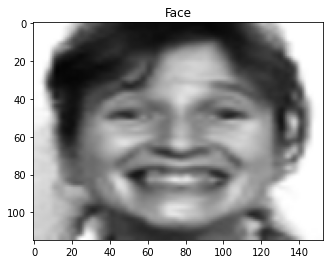

In [40]:
# 0번 사람의 얼굴 이미지
plt.title('Face')
plt.imshow(img_face_t[0])
print(img_face_t[0].shape)
print(num_face_t[0])

(115, 153, 3)
0


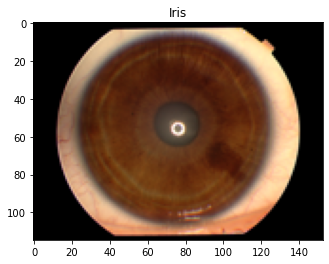

In [41]:
# 0번 사람의 홍채 이미지
plt.title('Iris')
plt.imshow(img_iris_t[0], cmap='gray')
print(img_iris_t[0].shape)
print(num_iris_t[0])

In [42]:
# X_test로 얼굴, 홍채 합치기
X_test = np.concatenate([img_face_t, img_iris_t], axis=1)
y_test = y_face # y_face=y_iris

In [43]:
X_test = np.array(X_test)
X_test = X_test.astype('float32')

In [44]:
preds = np.argmax(model.predict(X_test), axis=1)
preds

array([27, 36,  2, 46, 50, 10, 61, 49, 59, 56, 13, 31, 37, 30, 25,  0, 41,
       58,  9, 20, 48, 47, 22, 42, 24,  3,  6, 55, 63, 21, 16, 34, 11, 57,
       35, 32, 40, 62, 19, 52, 33, 15,  1, 29, 54, 17, 26, 53, 28, 18, 14,
       43, 60,  4, 39, 45, 38, 23, 51, 44,  5, 12,  8,  7])

In [45]:
import pandas as pd
res_df = pd.DataFrame(num_face_t, columns=['Image'], dtype='int32')
res_df['Answer'] = pd.Series(preds, dtype='int32')
res_df.sort_values(by=['Image'], axis=0, inplace=True)
res_df

,Image,Answer
0,0,27
11,1,31
22,2,22
33,3,57
44,4,54
...,...,...
54,59,39
56,60,38
57,61,23
58,62,51


In [46]:
res_df['Answer'].value_counts()

0     1
1     1
34    1
35    1
36    1
     ..
26    1
27    1
28    1
29    1
63    1
Name: Answer, Length: 64, dtype: int64

In [47]:
res_df.to_csv('./1871085_멀티모달_2차_답안_모델1개_1.csv', index=False)